<a href="https://colab.research.google.com/github/biglool/Hologram_Cell_detection/blob/main/notebooks/test%20pismip/PSMIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#%cd '/content/gdrive/MyDrive/Curro/Hologrames/'

Mounted at /content/gdrive


In [ ]:
!pip install ipywidgets pillow matplotlib

paso a paso

In [ ]:
%cd '/content/gdrive/MyDrive/Curro/Hologrames/'

/content/gdrive/MyDrive/Curro/Hologrames


Datos_reales/2024_01_25/Samples_01_normalized_mosaicimg_00000.tiff


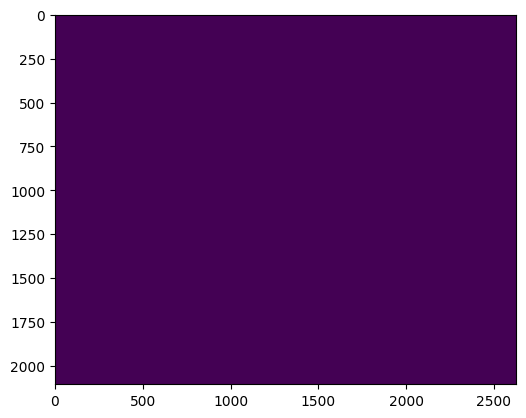

Datos_reales/2024_01_25/Samples_03_2_normalized_mosaicimg_00000.tiff


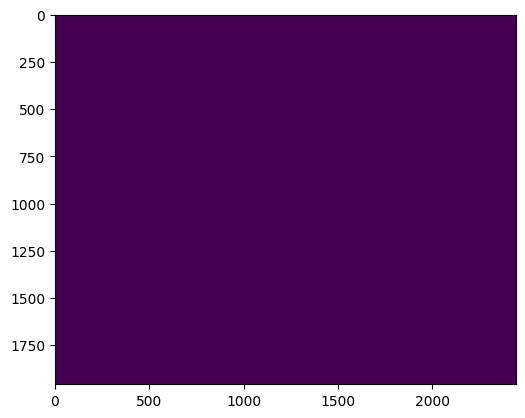

Datos_reales/2024_01_25/Samples_04_1_normalized_mosaicimg_00000.tiff


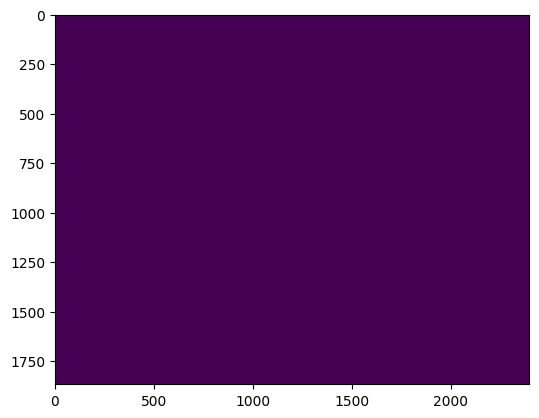

In [ ]:

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json


carpeta_imatges= "Datos_reales/2024_01_25/"

mostres=["Samples_01_normalized_mosaic", #c78d304a592045bb8048e9d639dbb599

    "Samples_03_2_normalized_mosaic",
    "Samples_04_1_normalized_mosaic",
]

step=1
margen_de_proyeccion=range(-30,30,step)
capture_file = carpeta_imatges+'capture_collection.json'

with open(capture_file, 'r') as file:
    capture_data = json.load(file)

def find_annotations_for_image(image_uid, analysis_data):
      for key, value in analysis_data.items():
          if 'iid' in value and value['iid'] == image_uid:
              return value.get('mount', [])
      return []

for imagen_name in mostres:

  if os.path.exists(carpeta_imatges+imagen_name):
    for f in os.listdir(carpeta_imatges+imagen_name):
      print(carpeta_imatges+imagen_name+f)
      #mount info
      mount=find_annotations_for_image(imagen_name, capture_data)
      im=Image.open(carpeta_imatges+imagen_name+"/"+f)
      l=mount["wavelength"]* 1e-9
      h=im.size[1] * mount["pitch_camera"]* 1e-6
      z=mount["distance_display_camera"]* 1e-3
      z0=mount["distance_display_sample"]* 1e-6
      twin_image_iterations=5
      apodization=118

      #first projection
      #base_image=np.zeros((im.size[1],im.size[0]))
      im=apodize(im,int((apodization/4)*3))
      proyeccion= np.angle(reconstruct_hologram_with_twin_image_removal(im,l,h,z,z0))
      plt.imshow(proyeccion)
      plt.show()

      '''
      recontruccions=[]
      for offset in margen_de_proyeccion:
        proyeccion= reconstruct_hologram_with_twin_image_removal(im,l,h,z,z0+offset)
        recontruccions.append(np.array(proyeccion))
      min_image=np.max(np.array(recontruccions), axis=0)
      plt.imshow(min_image)
      plt.show()
      '''



(20, 2105, 2627)
(2105, 2627)


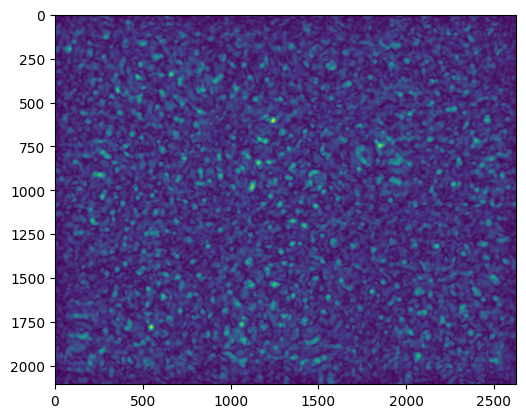

In [ ]:
print(np.array(recontruccions).shape)
min_image=np.max(np.array(recontruccions), axis=0)
print(min_image.shape)
plt.imshow(min_image)
plt.show()
#for image in recontruccions:
  #plt.imshow(image)
  #plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
def  genera_mascara( img_size, particles):
   # Define some data:
  N = img_size[1]
  M = img_size[0]

  # Define a meshgrid:
  XX, YY = np.meshgrid(np.arange(N), np.arange(M))

  particulas =[]
  particulas_interior=[]
  for x,y,r,r_in in particles:

    m = (XX-(N//2)+ x)**2 + (YY-(M//2)+ y)**2 > r**2
    m_in = (XX-(N//2)+x)**2 + (YY-(M//2)+y)**2 > r_in**2

    if len(particulas)==0:
      particulas=m
    else:
      particulas=particulas*m

    if len(particulas_interior)==0:
      particulas_interior=m_in
    else:
      particulas_interior=particulas_interior*m_in



  sim_image = (particulas) .astype(float)
  sim_image[~(particulas_interior )] = 0.85
  return sim_image



def generate_hologram( sim_image,mount ):


  # Rename measured distances:
  z = mount.get("distance_display_camera") * 1e-3
  z0 = mount.get("distance_display_sample") * 1e-6
  h = sim_image.shape[0] * mount.get("pitch_camera") * 1e-6

  # Convert the height of the sensor plane to the height in the hologram plane:
  size_y = z0 * h / z

  # Compute the area in the x-axis:
  size_x = size_y * sim_image.shape[1] / sim_image.shape[0]

  propagator = propagator_planar_fresnel(
      sim_image.shape[0],
      sim_image.shape[1],
      mount.get("wavelength") * 1e-9,
      size_x,
      size_y,
      z0
  )

  # Simulate the image by propagating the field:
  measured_image = ift2_dc(ft2_dc(sim_image) * propagator)

  return measured_image


def generate_random_cells(num_cels,img_size,max_z,min_z,max_radius,min_radius, percen_internal_max,percen_internal_min):
  # particulas [x, y , radi, radi intern, transparencia]
  cells=[]
  max_x = img_size[1]
  min_x=0
  max_y=img_size[0]
  min_y=0

  for i in range(num_cels):
    x=np.random.randint(min_x, max_x)
    y=np.random.randint(min_y, max_y)
    z=max_z if min_z>=max_z else np.random.randint(min_z, max_z)
    radius = max_radius if min_radius>=max_radius else np.random.randint(min_radius, max_radius)
    percen_internal =percen_internal_max if percen_internal_min>=percen_internal_max else  np.random.uniform(percen_internal_min, percen_internal_max)
    cells.append([x,y,z,radius,radius*percen_internal])

  return cells

def add_noise_to_array(array, noise_level):
    """
    Add Gaussian noise to a 2-dimensional array.

    Parameters:
    array (list of lists): The input 2D array.
    noise_level (float): The standard deviation of the Gaussian noise.

    Returns:
    np.array: The modified array with noise added.
    """
    # Convert the input list of lists to a numpy array
    array = np.array(array, dtype=float)

    # Generate Gaussian noise
    noise = np.random.normal(0, noise_level, array.shape)

    # Add the noise to the original array
    noisy_array = array + noise

    return noisy_array

def overlay_images(intensity, particles, image_size):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(intensity.real, cmap='gray')

    # Overlay particles from ground truth with red outlines
    for particle in particles:
        x_p, y_p, z_p, r_p ,r_in_p = particle
        adjusted_size = r_p
        # Adjust particle positions to image coordinates
        rect=patches.Rectangle((x_p-r_p, y_p-r_p), r_p*2, r_p*2, linewidth=1, edgecolor='r', facecolor='none')
        #circle = patches.Circle(( x_p , y_p ), radius=r_p /2, edgecolor='red', facecolor='none', linewidth=1.5, alpha=.5)
        ax.add_patch(rect)

    plt.title('Overlay of Ground Truth on Diffraction Image')
    plt.xlabel('X coordinate (pixels)')
    plt.ylabel('Y coordinate (pixels)')
    plt.show()


In [ ]:

def apodize(im: np.ndarray, length: int) -> np.ndarray:
    """
    Applies an apodization filter to an image. An apodization filter is a filter that reduces the
    intensity of the image at the borders, in this context it aims to reduce the ringing effect of
    the Fourier transform.

    Args:
        im: image to apply the filter to.
        length: length of the border to reduce the intensity of.

    Returns:
        The image with the apodization filter applied.
    """

    # Create a 1D apodization mask
    indices = np.arange(length)
    mask_1d = np.cos(np.pi / (2 * length) * (length - indices)) ** 2

    # Extend the mask to 2D
    mask_2d = np.ones_like(im, dtype=float)
    mask_2d[:length, :] *= mask_1d[:, np.newaxis]
    mask_2d[-length:, :] *= mask_1d[::-1, np.newaxis]
    mask_2d[:, :length] *= mask_1d[np.newaxis, :]
    mask_2d[:, -length:] *= mask_1d[np.newaxis, ::-1]

    # Apply the mask
    return im * mask_2d


In [ ]:
def detect_high(
        separation_pixels_camera: float,
        separation_pixels_display: float,
        pitch_camera: float,
        pitch_display: float,
        z: float
):
    """
    Detects the high of the camera above the display.

    Args:
        separation_pixels_camera: distance between pixels in the camera in meters
        separation_pixels_display: distance between pixels in the display in meters
        pitch_camera: number of pixels in the camera
        pitch_display: number of pixels in the display
        z: distance between the camera and the display in meters

    Returns:
        The high of the camera above the display in meters

    """
    a = separation_pixels_display * pitch_display
    b = separation_pixels_camera * pitch_camera
    return z * a / (a + b)

In [ ]:
def normalize_image_for_extractor(im):

        # If the image has negative values (is a relative signal) convert it to positive by adding one:
        if im.min() < 0:
            im = im + 1
        # If the image is not in 8-bits or 16-bits convert to 16-bits:
        if im.dtype != np.uint8:
            if im.max() > 1:
                im = (im - im.min()) / (im.max() - im.min())
            im = (255 * im).astype(np.uint8)
        return im

In [ ]:
import skimage.transform
from skimage import img_as_float
from skimage import io
from typing import List, Tuple, Union, Callable

def mosaic_model(
        images: List[np.ndarray],
        nx: int,
        ny: int,
        ddx: np.ndarray,
        ddy: np.ndarray,
        dddx_dx: np.ndarray = np.array([0, 0]),
        dddx_dy: np.ndarray = np.array([0, 0]),
        dddy_dx: np.ndarray = np.array([0, 0]),
        dddy_dy: np.ndarray = np.array([0, 0]),
        fact_augment: float = 1,
        wiggle: int = 0,
        stack: bool = True,
        cut: bool = True
) -> np.ndarray:
    """
    A function to stitch a grid of images. It uses the definition of the displacement vectors derived from a
    matching SIFT features. The displacement vectors are defined as `ddx` and `ddy`, which are the displacement
    vector to the right and downwards, respectively. And its second order derivates (`dddx_dx`, `dddx_dy`,
    `dddy_dx` and `dddy_dy`). We have observed that the second derivates effects comes from an inconsistent
    scaling of the images. That is why in this function we also rescale the images to make them fit into
    the mosaic. Instead of calculating the displacement vector for each image with respect to the previous
    one (which is inconsistent depending on whether we do it with respect to the image above or to the left),
    we scale each image so that the displacement vectors (scaled) approximately match those of the first image
    (i = j = 0). Thus, with fixed `ddx` and `ddy` we can complete the mosaic.

    Args:
        images: list of images to stitch.
        nx: number of images in the x-axis.
        ny: number of images in the y-axis.
        ddx: derivative of the displacement vector to the right.
        ddy: derivative of the displacement vector downwards.
        dddx_dx: second derivative of the displacement vector to the right.
        dddx_dy: cross derivative of the displacement vector to the right and downwards.
        dddy_dx: cross derivative of the displacement vector downwards and to the right.
        dddy_dy: second derivative of the displacement vector downwards.
        fact_augment:
            factor by which we scale the images to improve the stitching, or save time if it is less than 1.
        wiggle:
            margin (in number of pixels) that we give the algorithm to find a better starting point for each image.
        stack:
            whether if true we average the overlapping images, or not, and therefore put the newest one on top.
        cut:
            whether if true we cut the final image to remove white space at the end of everything.

    Returns:
        mosaic: the stitched image.

    """
    # We compute a mean of the "scale" of each image
    original = np.linalg.norm(ddx) + np.linalg.norm(ddy)

    # We scale the images
    ims_scaled = [
        skimage.transform.rescale(
            images[nx * i + j],
            fact_augment / (
                    np.linalg.norm(ddx + i * dddx_dy + j * dddx_dx) +
                    np.linalg.norm(ddy + i * dddy_dy + j * dddy_dx)
            ) * original
        ) for i in range(ny) for j in range(nx)
    ]

   # print("originals")
    #for im in images:
     # print(im.shape)

   # print("escalats")
    #for im in ims_scaled:
     # print(im.shape)

    # We compute the maximum dimensions of the final image
    h, w = ims_scaled[0].shape
    hmax = max(
        ims_scaled[0].shape[0],
        ims_scaled[nx - 1].shape[0],
        ims_scaled[nx*(ny-1)].shape[0],
        ims_scaled[-1].shape[0]
    )
    wmax = max(
        ims_scaled[0].shape[1],
        ims_scaled[nx - 1].shape[1],
        ims_scaled[nx*(ny-1)].shape[1],
        ims_scaled[-1].shape[1]
    )

    # We compute the displacement vectors for each image:
    ddx *= fact_augment
    ddy *= fact_augment

    # Initial point of the first image
    x0 = nx + ny - 2 + round(
        wiggle * (nx + ny - 2) + max(
            0,
            - (nx - 1) * ddx[0],
            - (ny - 1) * ddy[0],
            - (nx - 1) * ddx[0] - (ny - 1) * ddy[0]
        )
    )
    y0 = nx + ny - 2 + round(
        wiggle * (nx + ny - 2) + max(
            0,
            - (nx - 1) * ddx[1],
            - (ny - 1) * ddy[1],
            - (nx - 1) * ddx[1]
            - (ny - 1) * ddy[1]
        )
    )

    # Dimensions of the final image
    W = 2 * (nx + ny - 2) + round(
        2 * wiggle * (nx + ny - 2) + x0 + wmax + max(
            0,
            (nx - 1) * abs(ddx[0]),
            (ny - 1) * abs(ddy[0]),
            (nx - 1) * abs(ddx[0] + (ny - 1) * ddy[0]))
    )
    H = 2 * (nx + ny - 2) + round(
        2 * wiggle * (nx + ny - 2) + y0 + hmax + max(
            0,
            (nx - 1) * abs(ddx[1]),
            (ny - 1) * abs(ddy[1]),
            abs((nx - 1) * ddx[1] + (ny - 1) * ddy[1])
        )

    )

    min_start_x = x0
    min_start_y = y0
    max_end_x = 0
    max_end_y = 0

    # Initialize the mosaic image:
    im_final = np.zeros((H, W), dtype=float)

    # Initialize the layers image
    layers = np.zeros((H, W), dtype=float)

    im_final[y0: y0 + h, x0: x0 + w] = ims_scaled[0]
    layers[y0: y0 + h, x0: x0 + w] = 1

    prev_start = np.array([x0, y0])
    prev_row_start = prev_start

    # We iterate over the images to stitch them
    for i in range(ny):
        for j in range(nx):
            if i != 0 or j != 0:

                # Get the image to be stitched
                im = ims_scaled[nx * i + j]
                h, w = im.shape

                if j == 0:
                    s = prev_row_start + ddy
                else:
                    s = prev_start + ddx

                sx0 = round(s[0])
                sy0 = round(s[1])

                # Initialize the score at infinity
                score_final = float('inf')

                finalsx, finalsy = sx0, sy0
                finalex, finaley = sx0 + w, sy0 + h

                # We iterate over the possible starting points to find the best one:
                for wigglex in range(-wiggle, wiggle + 1):
                    for wiggley in range(-wiggle, wiggle + 1):

                        # Initial point of the image
                        sx = sx0 + wigglex
                        sy = sy0 + wiggley
                        ex = sx + w
                        ey = sy + h

                        # We compute the score of the image
                        prev = im_final[sy: ey, sx: ex]
                        layersPrev = layers[sy: ey, sx: ex]

                        score = np.linalg.norm(im * layersPrev - prev) / (1 + np.sum(layersPrev))

                        if score < score_final:
                            score_final = score
                            finalsx, finalsy, finalex, finaley = sx, sy, ex, ey

                prev_start = np.array([finalsx, finalsy])
                if j == 0:
                    prev_row_start = prev_start

                min_start_x = min(min_start_x, finalsx)
                max_end_x = max(max_end_x, finalex)
                min_start_y = min(min_start_y, finalsy)
                max_end_y = max(max_end_y, finaley)

                if stack:
                    # Assign the pixels
                    im_final[finalsy: finaley, finalsx: finalex] += im
                    layers[finalsy: finaley, finalsx: finalex] += 1
                else:

                    # Assign the pixels
                    im_final[finalsy: finaley, finalsx: finalex] = im
                    layers[finalsy: finaley, finalsx: finalex] = 1

    mask_0 = layers == 0

    layers[mask_0] = 1
    im_final /= layers

    # If the original images minimum is below 0, it means they are normalized [-1, inf), so
    #  we set the padding values to the real minimum, this is done to ease the visualization
    #  and the fourier transform, avoiding high frequencies.
    minimum = np.min([im.min() for im in images])
    if np.min([im.min() for im in images]) < 0:
        im_final[mask_0] = minimum

    if cut:
        im_final = im_final[min_start_y: max_end_y, min_start_x: max_end_x]

    return im_final

In [ ]:

import cv2
import copy

imaI = 0 + 1j

def compute_k_grid(
        detector_size_metric: np.ndarray,
        detector_size_pixels: np.ndarray,
        z: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the k-space grid for the provided detector size and distance from the detector to the sample.

    Args:
        detector_size_metric: a numpy array with the size of the detector in meters.
        detector_size_pixels: a numpy array with the size of the detector in pixels.
        z: distance from the detector to the sample in meters.

    Returns:
        Kx: a numpy array with the kx coordinates.
        Ky: a numpy array with the ky coordinates.

    """
    # Compute the maximal value for kx:
    k_max = detector_size_metric / np.sqrt(detector_size_metric**2 + z**2) / 2

    # Pixel size in k-coordinates:
    dk = 2 * k_max / detector_size_pixels

    # Create a vector for the kx and ky coordinates:
    kx = np.arange(0, detector_size_pixels[0]) - detector_size_pixels[0] / 2
    kx *= dk[0]
    ky = np.arange(0, detector_size_pixels[1]) - detector_size_pixels[1] / 2
    ky *= dk[1]

    # Create the grid:
    Kx, Ky = np.meshgrid(kx, ky)

    return Kx, Ky


def transform_image_to_k_coordinates(
        image: np.ndarray,
        detector_size: Union[Tuple[float, float], np.ndarray],
        z: float,

) -> np.ndarray:
    """
    Transforms an image to k-coordinates, where the x-axis is the horizontal axis and the y-axis is the vertical
    axis. The origin of the k-coordinates is the center of the image.

    Args:
        image: the image to transform.
        detector_size: size of the detector in meters.
        z: distance from the detector to the sample in meters.

    Returns:
        transformed_im: the transformed image.
    """
    # Ensure that the detector size is a numpy array:
    detector_size_metric = np.asarray(detector_size)
    detector_size_pixels = np.asarray(image.shape)[::-1]

    # Compute the maximal value for kx:
    Kx, Ky = compute_k_grid(detector_size_metric, detector_size_pixels, z)

    # Compute the k-coordinates:
    X = z * Kx / np.sqrt(1 - Kx**2 - Ky**2)
    Y = z * Ky / np.sqrt(1 - Kx**2 - Ky**2)

    # Compute the pixel coordinates:
    X2 = X * detector_size_pixels[0] / (2 * X.max()) + detector_size_pixels[0] / 2
    Y2 = Y * detector_size_pixels[1] / (2 * Y.max()) + detector_size_pixels[1] / 2

    # Interpolate the image:
    transformed_im = cv2.remap(
        image,
        X2.astype(np.float32),
        Y2.astype(np.float32),
        interpolation=cv2.INTER_LINEAR
    )

    return transformed_im

def reconstruct_hologram_with_twin_image_removal(
        im: np.ndarray,
        l: float = 500e-9,
        h: float = 0.05,
        z: float = 0.1,
        z0: float = 0.08,
        twin_image_iterations: int = 1,
) -> np.ndarray:

    # If the twin image iterations are 0, we return the original method, which is:
    if twin_image_iterations == 0:
        return reconstruct_hologram_spherical(im, l, h, z, z0, method='paraxial')

    # Create an initial phase and complex field detector:
    phase = np.zeros(im.shape, dtype=np.float64)
    field_detector = np.ones(im.shape, dtype=np.complex128)

    # Convert the height of the sensor plane to the height in the hologram plane:
    size_y = z0 * h / z

    # Convert the height to the width:
    size_x = size_y * im.shape[1] / im.shape[0]

    # Create a wave propagation operator:
    propagator = propagator_spherical_paraxial(
        im.shape[0],
        im.shape[1],
        l,
        size_x,
        size_y,
        z0
    )

    for ii in range(twin_image_iterations):
        # Multiply the measured image by the last phase detector:
        field_detector = im * np.exp(1j * phase)

        t = ift2_dc(ft2_dc(field_detector) * np.conj(propagator))

        # Split the field detector into amplitude and phase:
        amplitude_t = np.abs(t)
        phase_t = np.angle(t)

        # Filter the amplitude, more than one means this is part of the twin-image:
        mask = amplitude_t > 1

        # Apply morphological operations to smooth the mask:
        mask = cv2.morphologyEx(
            mask.astype(np.uint8),
            cv2.MORPH_CLOSE,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        ).astype(bool)
        mask = cv2.morphologyEx(
            mask.astype(np.uint8),
            cv2.MORPH_OPEN,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        ).astype(bool)

        # Apply constraints:
        # amplitude_log[mask] = 0

        phase_t[mask] = 0

        # Expand again the amplitude:
        # amplitude_t = np.exp(- amplitude_log)
        amplitude_t[mask] = 1

        # Convert amplitude and phase to complex field:
        t2 = amplitude_t * np.exp(1j * phase_t)

        # Compute the inverse Fourier transform of the product of the propagator and the Fourier
        #  transform of the hologram, a.k.a backpropagation:
        field_detector_updated = ift2_dc(ft2_dc(t2) * propagator)

        # Compute the new phase:
        phase = np.angle(field_detector_updated)

    reconstructed_image = ift2_dc(ft2_dc(field_detector) * np.conj(propagator))

    return np.abs(reconstructed_image)


def reconstruct_hologram_spherical(
        im: np.ndarray,
        l: float = 500e-9,
        h: float = 0.05,
        z: float = 0.1,
        z0: float = 0.08,
        method: str = 'paraxial',
) -> np.ndarray:
    """
    Reconstructs a hologram using the Fresnel transform for a spherical wave.

    Args:
        im: the original hologram image.
        l: the wavelength of the light, in meters.
        h: the size of the height of the sensor plane, in meters.
        z: the distance between the sensor and the light source, in meters.
        z0: the distance between the light source and the hologram, in meters.
        method:
            the method to use for the Fresnel transform for spherical waves. As for now, it only
            supports 'paraxial'.

    Returns:
        The reconstructed image.

    Raises:
        ValueError: if the method is not known.
    """
    # Convert the height of the sensor plane to the height in the hologram plane:
    size_y = z0 * h / z

    # Compute the area in the x-axis:
    size_x = size_y * im.shape[1] / im.shape[0]

    if method == 'non-paraxial':
        Kx, Ky = compute_k_grid(
            detector_size_metric=np.asarray([size_x, size_y]),
            detector_size_pixels=np.asarray(im.shape)[::-1],
            z=z,
        )
        J = z**2 / (1 - Kx**2 - Ky**2)
        im = J * transform_image_to_k_coordinates(
            im,
            detector_size=np.asarray([size_x, size_y]),
            z=z,
        )

    # Compute the propagator:
    prop = propagator_spherical_paraxial(
        im.shape[0],
        im.shape[1],
        l,
        size_x,
        size_y,
        z0
    )
    # Compute the inverse Fourier transform of the product of the propagator and the Fourier
    # transform of the hologram, a.k.a backpropagation:
    p = np.abs(ift2_dc(ft2_dc(im) * np.conj(prop)))

    return p


def reconstruct_hologram_planar(
        im: np.ndarray,
        l: float = 500e-9,
        h: float = 0.05,
        z: float = 0.1,
        z0: float = 0.08,
        method: str = 'fresnel',
) -> np.ndarray:
    """
    Reconstructs a hologram using the Fresnel transform for a plane wave.

    Args:
        im: the original hologram image.
        l: the wavelength of the light, in meters.
        h: the distance between pixels of the sensor, in meters.
        z: the distance between the sensor and the light source, in meters.
        z0: the distance between the sensor and the hologram, in meters.
        method:
            the method to use for the Fresnel transform for plane waves. As for now, it only
            supports 'fresnel' and 'angular_spectrum'.

    Returns:
        The reconstructed image.

    Raises:
        ValueError: if the method is not known.

    """
    # Convert the height of the sensor plane to the height in the hologram plane:
    size_y = z0 * h / z

    # Compute the area in the x-axis:
    size_x = size_y * im.shape[1] / im.shape[0]

    if method == 'fresnel':
        propagator_func = propagator_planar_fresnel

    elif method == 'angular_spectrum':
        propagator_func = propagator_planar_angular_spectrum_method

    else:
        raise ValueError(f'Unknown method {method}')

    # Compute the propagator:
    prop = propagator_func(
        im.shape[0],
        im.shape[1],
        l,
        size_x,
        size_y,
        z0
    )
    # Compute the inverse Fourier transform of the product of the propagator and the Fourier
    # transform of the hologram, a.k.a backpropagation:
    if method == 'fresnel':
        prop = np.conj(prop)
    p = np.abs(ift2_dc(ft2_dc(im) * prop))

    return p

def propagator_planar_fresnel(
        n: int,
        m: int,
        l: float,
        x: float,
        y: float,
        z: float,
) -> np.ndarray:
    """
    Computes the propagator component of the Fresnel transform for a plane wave propagating in the z-axis.

    Args:
        n: number of rows of the image, this is the pixel size of the image.
        m: number of columns of the image, this is the pixel size of the image.
        l:
            wavelength, usually called lambda of the light, in meters. So typical 500 nm values are
            expressed as 500e-9.
        x: size of the image in the x-axis, used to scale the propagator in the x-axis. In meters.
        y: size of the image in the y-axis, used to scale the propagator in the y-axis. In meters.
        z: distance of propagation in meters.

    Returns:
        p: an image of size (n, m) with the propagator component of the Fresnel transform.

    """

    x_range = np.arange(m)
    y_range = np.arange(n)
    X, Y = np.meshgrid(x_range, y_range)

    u = (Y - n / 2) / y
    v = (X - m / 2) / x

    p = np.exp(-imaI * np.pi * l * z * (u ** 2 + v ** 2))

    return p


def propagator_planar_angular_spectrum_method(
        n: int,
        m: int,
        l: float,
        x: float,
        y: float,
        z: float
) -> np.ndarray:
    """
    Computes the propagator component of the Fresnel transform for a plane wave with the
    angular spectrum method.

    Args:
        n: number of rows of the image, this is the pixel size of the image.
        m: number of columns of the image, this is the pixel size of the image.
        l:
            wavelength, usually called lambda of the light, in meters. So typical 500 nm values are
            expressed as 500e-9.
        x: size of the image in the x-axis, used to scale the propagator in the x-axis. In meters.
        y: size of the image in the y-axis, used to scale the propagator in the y-axis. In meters.
        z: distance of propagation in meters.

    Returns:
        p: an image of size (n, m) with the propagator component of the Fresnel transform.

    """

    x_range = np.arange(m)
    y_range = np.arange(n)
    X, Y = np.meshgrid(x_range, y_range)

    u = (Y - n / 2) / y
    v = (X - m / 2) / x

    p = np.exp(-2 * np.pi * imaI * z * np.sqrt(1 - (l * u) ** 2 - (l * v) ** 2) / l)

    # Re-implement the filter to avoid NaN:
    p[np.isnan(p)] = 0

    return p


propagator_spherical_paraxial = copy.copy(propagator_planar_fresnel)
propagator_spherical_paraxial.__doc__ = """
    Computes the propagator component of the Fresnel transform for a spherical wave propagating in the z-axis.
        Args:
        n: number of rows of the image, this is the pixel size of the image.
        m: number of columns of the image, this is the pixel size of the image.
        l:
            wavelength, usually called lambda of the light, in meters. So typical 500 nm values are
            expressed as 500e-9.
        x: size of the image in the x-axis, used to scale the propagator in the x-axis. In meters.
        y: size of the image in the y-axis, used to scale the propagator in the y-axis. In meters.
        z: distance of propagation in meters.

    Returns:
        p: an image of size (n, m) with the propagator component of the Fresnel transform.

    """


def ft2_dc(img: np.ndarray) -> np.ndarray:
    """
    Computes the 2D Fourier transform of an image with a DC term, that is, the Fourier transform
    multiplied by a phase factor.

    Args:
        img: image to compute the Fourier transform.

    Returns:
        The Fourier transform of the image.
    """

    y, x = img.shape
    x_range = np.arange(x)
    y_range = np.arange(y)
    X, Y = np.meshgrid(x_range, y_range)

    # Create a phase factor:
    phase = np.exp(imaI * np.pi * (X + Y))

    fourier_transform = np.fft.fft2(phase * img)

    return phase * fourier_transform


def ift2_dc(arr: np.ndarray) -> np.ndarray:
    """
    Computes the inverse 2D Fourier transform of an image with a DC term, that is, the inverse
    Fourier transform multiplied by a phase factor.

    Args:
        arr: array to compute the inverse Fourier transform.

    Returns:
        The inverse Fourier transform of the array, as a numpy image.
    """
    y, x = arr.shape
    x_range = np.arange(x)
    y_range = np.arange(y)
    X, Y = np.meshgrid(x_range, y_range)

    phase = np.exp(-imaI * np.pi * (X + Y))

    i_fourier_transform = np.fft.ifft2(phase * arr)
    return phase * i_fourier_transform